In [3]:
%load_ext autoreload
%autoreload 2

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [4]:
useNet = 'CNN2P2'
iterations = 1
learningRate = 2e-2
verbose = True

# Prepare Network and Preprocessing
batchSize = 1000
if useNet=='CNN2P2':
    convActivation = F.relu
    linearActivation = F.relu
    net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
    ])
elif useNet=='MLP4':
    actFunc = F.relu
    net = models.MLP4(actFunc=actFunc,pDropout=pDropout)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        transforms.Lambda(torch.flatten), # convert to vectors
    ])
else:
    raise ValueError('useNet not recognized')

net.to(DEVICE)

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
optimizer = torch.optim.SGD(net.parameters(), lr=learningRate)
# optimizer = torch.optim.Adadelta(net.parameters())

# Preallocate summary variables  
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []

# Measuring initial features of network
initWeights = net.getNetworkWeights()
initEval,initEvec = net.inputEigenfeatures(net, testloader, onlyFF=False, DEVICE=DEVICE)
allEval = []
allEvec = []

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,batch in enumerate(trainloader):
        cidx = epoch*len(trainloader) + idx

        images, label = batch
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Measure Integration
        alignFull.append(net.measureAlignment(images))
        
        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]
    
    # Measure Eigenstructure
    ceval,cevec = net.inputEigenfeatures(net, testloader, onlyFF=False, DEVICE=DEVICE)
    allEval.append(ceval)
    allEvec.append(cevec)
    
    # Print statistics for each epoch
    if verbose: print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))

# Measure performance on test set
totalLoss = 0
numCorrect = 0
numAttempted = 0
for batch in testloader:
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    outputs = net(images)
    totalLoss += loss_function(outputs,label).item()
    output1 = torch.argmax(outputs,axis=1)
    numCorrect += sum(output1==label)
    numAttempted += images.shape[0]
    
print(f"Average loss over test set: %.2f." % (totalLoss / len(testloader)))
print(f"Accuracy over test set: %.2f%%." % (100*numCorrect/numAttempted))
print('Training process has finished in %.3f seconds.' % (time.time()-t))

Loss in epoch   0: 2.185, Accuracy: 40.50%.
Average loss over test set: 2.18.
Accuracy over test set: 41.11%.
Training process has finished in 23.086 seconds.


In [9]:
net.o.weight.shape

torch.Size([10, 256])

In [8]:
net

CNN2P2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (o): Linear(in_features=256, out_features=10, bias=True)
)

In [6]:
useLayer = 0


(100, 784)

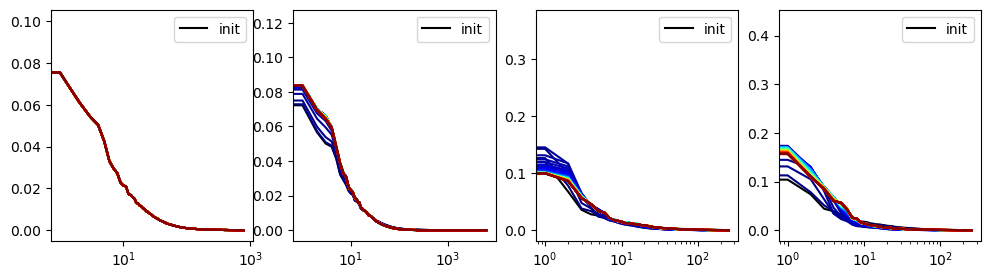

In [15]:
scaleFunc = lambda x : x / np.sum(x)

numMeasurements = len(allEval)
colorNorm = colors.Normalize(vmin=0,vmax=numMeasurements)
getColor = lambda s : cm.jet(colorNorm(s))

useLines = True
numLayers = len(initEvec)
fig,ax = plt.subplots(1,numLayers,figsize=(12,3))
for nl in range(numLayers):
    if useLines:
        ax[nl].plot(scaleFunc(initEval[nl]),c='k',label='init')
        for nm in range(numMeasurements):
            ax[nl].plot(scaleFunc(allEval[nm][nl]),c=getColor(nm))
        ax[nl].legend()
        ax[nl].set_xscale('log')
        #ax[nl].set_yscale('log')
    else:
        cdata = np.stack([aeval[nl] for aeval in allEval])
        ndata = cdata / np.sum(cdata,axis=1,keepdims=True)
        ndata = ndata / ndata[0]
        ax[nl].imshow(ndata[:,:100])

In [ ]:
len(allEval[nl])

4

In [ ]:
allinputs = torch.cat([batch[0].to(DEVICE) for batch in testloader])

In [ ]:
allinputs.shape

torch.Size([10000, 1, 28, 28])

In [ ]:
ccov = torch.cov(torch.flatten(allinputs,1).T)
ccov.shape

torch.Size([784, 784])

In [ ]:
3==3==2

False

In [ ]:
xx = np.arange(0,5).reshape(-1,1) + np.arange(0,5).reshape(1,-1)
xx

ym = np.repeat(np.arange(0,5).reshape(1,-1),10,axis=0)
out = xx[:,:,None] * ym[:,:,None].transpose(2,1,0)
out.shape

(5, 5, 10)

In [ ]:
out[:,:,0]

array([[ 0,  1,  4,  9, 16],
       [ 0,  2,  6, 12, 20],
       [ 0,  3,  8, 15, 24],
       [ 0,  4, 10, 18, 28],
       [ 0,  5, 12, 21, 32]])

In [ ]:
B,N,O = 10,100,20
xx = np.random.normal(0,1,(B,N,N))
w = np.random.normal(0,1,(O,N))
oein = np.einsum('bnd,od->bon',xx,w)
output = np.sum(np.array([(bxx[:,:,None] * w[:,:,None].transpose(2,1,0)) for bxx in xx]),axis=2).transpose(0,2,1)
ofor = np.zeros((B,O))
for b in range(B):
    for o in range(O):
        ofor[b,o] = np.sum(np.sum(xx[b] * w[o],axis=1),axis=0)
sein = np.einsum('bnd,od->bo',xx,w)
print(oein.shape)
print(output.shape)
print(ofor.shape)
print(np.allclose(oein,output))
print(np.allclose(sein,ofor))

(10, 20, 100)
(10, 20, 100)
(10, 20)
True
True


In [ ]:
output.shape

(100, 100, 10)

In [ ]:
net.fc1.bias.shape

torch.Size([256])

In [99]:


acts = forwardLayer(net.fc1,torch.normal(0,1,(51,256,256)).to(DEVICE))
acts.shape

torch.Size([51, 256])

TypeError: Image data of dtype complex128 cannot be converted to float

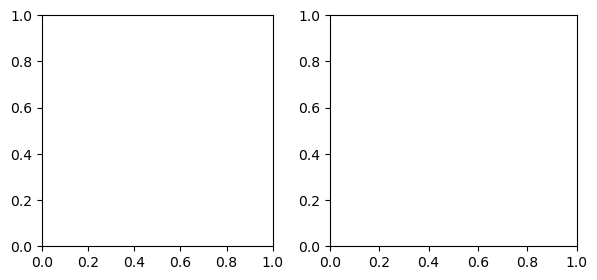

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].imshow(iVs@Vs)
ax[1].imshow(iiVs@Vs)

In [262]:
Q.shape

(100, 10)

CPU times: total: 641 ms
Wall time: 164 ms
CPU times: total: 156 ms
Wall time: 8 ms
False
False
True
True


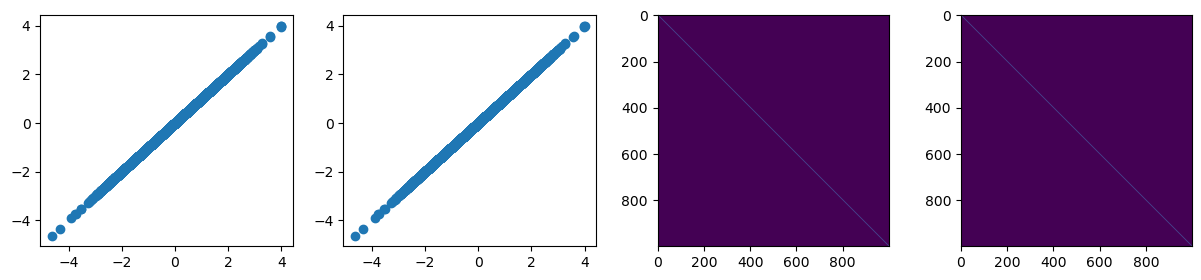

In [269]:
from scipy.linalg import qr

B,N = 15,1000
rank = 999

# Create random eigenvectors & eigenvalues
H = np.random.randn(N,N)
Q,R = qr(H)
w = 1.000001**(-np.arange(N)) # create powerlaw scalings
w[rank:] = 0
idxNonzero = np.nonzero(w)[0]

# Keep only those requested (in rank of matrix) and scale eigenvectors by eigenvalues
Q = Q[:,idxNonzero]
w = w[idxNonzero]
Qs = Q @ np.diag(w)

# Create random data from basis
trueCoeff = np.random.normal(0,1,(B,rank))
D = trueCoeff @ Q.T

# Inverse Methods
%time iQs1 = np.linalg.pinv(Qs)
%time iQs2 = np.diag(1/w) @ Q.T

# Get coefficients
def getCoeffAndRemake(invmat,scalemat,data):
    coeff = np.squeeze(np.matmul(invmat[:,:,None].transpose(2,0,1), data[:,:,None]),axis=2)
    remake = np.sum(coeff[:,:,None].transpose(0,2,1) * scalemat[:,:,None].transpose(2,0,1),axis=2)
    return coeff,remake

a1,r1 = getCoeffAndRemake(iQs1,Qs,D)
a2,r2 = getCoeffAndRemake(iQs2,Qs,D)

# Compare true and estimated coefficients
print(np.allclose(trueCoeff,a1))
print(np.allclose(trueCoeff,a2))
print(np.allclose(r1,D))
print(np.allclose(r2,D))

fig,ax = plt.subplots(1,4,figsize=(15,3))
ax[0].scatter(r1[:],D[:])
ax[1].scatter(r2[:],D[:])
ax[2].imshow(Q.T@Q)
ax[3].imshow(iQs2@Qs);

In [254]:
B,N = 80,500

rank = 20

# Create random data
D = np.random.normal(0,1,(B,N))

# Create random eigenvectors & eigenvalues
H = np.random.randn(N,N)
V,R = qr(H)
w = 1.1**(-np.arange(N)) # create powerlaw scalings
# w[rank:] = 0
# idxNonzero = np.nonzero(w)[0]

# Keep only those requested (in rank of matrix) and scale eigenvectors by eigenvalues
# Q = Q[:,idxNonzero]
# w = w[idxNonzero]
Vs = V @ np.diag(w)
iVs = np.linalg.inv(Vs)
iiVs = np.linalg.inv(np.diag(w)) @ V.T


# V = np.random.normal(0,1,(N,N))
# w,v = np.linalg.eig(V)
# Vs = V * w.reshape(1,-1)
# iVs = np.linalg.inv(Vs)
# iiVs = np.linalg.inv(np.diag(w)) @ V.T
# D = np.random.normal(0,1,(B,N))

# Get coefficients
%time xx = np.einsum('mn,bn->bm',iVs,D)
%time yy = np.array([iVs@d for d in D])
%time bb = np.squeeze(np.matmul(iVs[:,:,None].transpose(2,0,1), D[:,:,None]),axis=2)
%time ss = np.squeeze(np.matmul(iiVs[:,:,None].transpose(2,0,1), D[:,:,None]),axis=2)
# Remake data
xrr = np.sum(xx[:,:,None].transpose(0,2,1) * Vs[:,:,None].transpose(2,0,1),axis=2)
yrr = np.sum(yy[:,:,None].transpose(0,2,1) * Vs[:,:,None].transpose(2,0,1),axis=2)
brr = np.sum(bb[:,:,None].transpose(0,2,1) * Vs[:,:,None].transpose(2,0,1),axis=2)
srr = np.sum(ss[:,:,None].transpose(0,2,1) * Vs[:,:,None].transpose(2,0,1),axis=2)
# Check coefficients are the same
print(np.allclose(xx,yy))
print(np.allclose(xx,bb))
print(np.allclose(xx,ss))
# Check remake worked
print(np.allclose(xrr,D))
print(np.allclose(yrr,D))
print(np.allclose(brr,D))
print(np.allclose(srr,D))

CPU times: total: 0 ns
Wall time: 4 ms
CPU times: total: 0 ns
Wall time: 3 ms
CPU times: total: 0 ns
Wall time: 2 ms
CPU times: total: 15.6 ms
Wall time: 2 ms
True
True
True
True
True
True
True


(100, 85)

In [135]:
Vs.shape

(1000, 1000)

In [ ]:
N = 100
w = 

In [118]:

n = 3
H = np.random.randn(n, n)
Q, R = qr(H)

print (Q.dot(Q.T))

[[ 1.00000000e+00  1.27389364e-16 -1.61484707e-16]
 [ 1.27389364e-16  1.00000000e+00 -3.62253618e-17]
 [-1.61484707e-16 -3.62253618e-17  1.00000000e+00]]


CPU times: total: 0 ns
Wall time: 1 ms
CPU times: total: 0 ns
Wall time: 0 ns


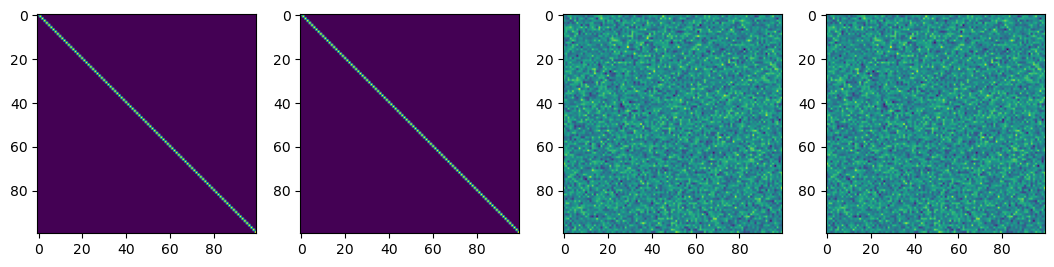

In [166]:
from scipy.linalg import qr

N = 100
H = np.random.randn(N,N)
Q, R = qr(H)

w = 1.000001**(-np.arange(N)) # create powerlaw scalings

Qs = Q * w.reshape(1,-1)
%time iQs = np.linalg.inv(np.diag(w)) @ Q.T
%time iiQs = np.diag(1/w) @ Q.T

fig,ax = plt.subplots(1,4,figsize=(13,3))
ax[0].imshow(Q.T@Q)
ax[1].imshow(iiQs@Qs)
ax[2].imshow(Q)
ax[3].imshow(Qs)



In [221]:
def projectData(evecs,evals,batch):
    # project batch data onto evecs (scaled by evals)
    # find coefficients "projcoeff" such that (V@D)@projcoeff=b for b in batch
    iEvScaled = torch.diag(1/evals) @ evecs.T
    projcoeff = torch.squeeze(torch.matmul(iEvScaled[:,:,None].permute(2,0,1), batch[:,:,None]),dim=2)
    return projcoeff

def projectDataSlow(evecs,evals,batch):
    # project batch data onto evecs (scaled by evals)
    # find coefficients "projcoeff" such that (V@D)@projcoeff=b for b in batch
    evScaled = evecs * evals.reshape(1,-1) 
    iEvScaled = torch.linalg.inv(evScaled)
    projcoeff = torch.squeeze(torch.matmul(iEvScaled[:,:,None].permute(2,0,1), batch[:,:,None]),dim=2)
    return projcoeff

from scipy.linalg import qr

B = 50
N = 1000
H = np.random.randn(N,N)
Q, R = qr(H)
Q = torch.tensor(Q,dtype=torch.float32)
w = 2.**(-np.arange(N)) # create powerlaw scalings
w = torch.tensor(w,dtype=torch.float32)
Qw = Q @ torch.diag(w)
idxNonzero = torch.nonzero(w)
Q = Q[:,idxNonzero]
w = w[idxNonzero]
Qw = Qw[:,idxNonzero]

batch = torch.normal(0,1,(B,N))
%time pc = projectData(Q,w,batch)
%time pcs = projectDataSlow(Q,w,batch)
rpc = torch.sum(pc[:,:,None].permute(0,2,1) * Qw[:,:,None].permute(2,0,1),dim=2)
rpcs = torch.sum(pcs[:,:,None].permute(0,2,1) * Qw[:,:,None].permute(2,0,1),dim=2)
print(torch.allclose(batch,rpc))
print(torch.allclose(batch,rpcs))

C:\Users\andrew\AppData\Local\Temp\ipykernel_13616\2266760638.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2985.)
  iEvScaled = torch.diag(1/evals) @ evecs.T


RuntimeError: size mismatch, got 1000, 1000x150,1

_LinAlgError: torch.linalg.inv: (Batch element 0): The diagonal element 17 is zero, the inversion could not be completed because the input matrix is singular.

RuntimeError: number of dims don't match in permute

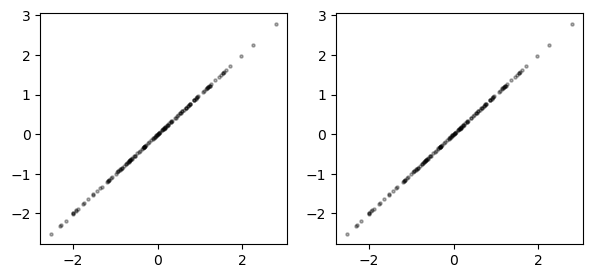

In [214]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].scatter(batch[:],rpc[:],s=5,c='k',alpha=0.3)
ax[1].scatter(batch[:],rpcs[:],s=5,c='k',alpha=0.3)